In [ ]:
!pip install numpy
!pip install matplotlib

# ***Introduction***




**OpenMP(Open Multi Processing) is An Application Program Interface (API) that may be used to explicitly direct multi-threaded, shared memory parallelism**

Goals of OpenMP:


1.   Standardization:
Provide a standard among a variety of shared memory architectures/platforms
Jointly defined and endorsed by a group of major computer hardware and software vendors
2.   Lean and Mean:
Establish a simple and limited set of directives for programming shared memory machines.
Significant parallelism can be implemented by using just 3 or 4 directives.
This goal is becoming less meaningful with each new release, apparently.
3.   Ease of Use:
Provide capability to incrementally parallelize a serial program, unlike message-passing libraries which typically require an all or nothing approach
Provide the capability to implement both coarse-grain and fine-grain parallelism
4.   Portability:
The API is specified for C/C++ and Fortran
Public forum for API and membership
Most major platforms have been implemented including Unix/Linux platforms and Windows

![](https://encyclopedia.pub/media/common/202210/mceclip1-634f75683a964.png)









# ***OpenMP Programming Model***



*   Memory Model : OpenMP is designed for multi-processor/core, shared memory machines.
![Image Description](https://hpc-tutorials.llnl.gov/openmp/images/uma.gif)


*   Execution Model :


1.   Thread Based Parallelism:
OpenMP programs accomplish parallelism exclusively through the use of threads. A thread of execution is the smallest unit of processing that can be scheduled by an operating system.
2.   Fork - Join Model:
OpenMP uses the fork-join model of parallel execution:
![](https://hpc-tutorials.llnl.gov/openmp/images/fork_join.gif)

FORK: the master thread then creates a team of parallel threads.

JOIN: When the team threads complete the statements in the parallel region construct, they synchronize and terminate, leaving only the master thread.



*   Compiler Directive Based:


Most OpenMP parallelism is specified through the use of compiler directives which are imbedded in C/C++ or Fortran source code.






# ***OpenMP API Overview***

The OpenMP API is comprised of three distinct components. As of version 4.0:

*   Compiler Directives: -
    Compiler directives appear as comments in your source code and are ignored by compilers unless you tell them otherwise - usually by specifying the appropriate compiler flag, as discussed in the Compiling section later.

  OpenMP compiler directives are used for various purposes:

1. Dividing blocks of code among threads
2. Distributing loop iterations between threads
3. Serializing sections of code
4. Synchronization of work among threads
5. Spawning a parallel region
  syntax: - #pragma omp parallel default(shared) private(beta,pi)
*   Runtime Library Routines
    The OpenMP API includes an ever-growing number of run-time library routines.

These routines are used for a variety of purposes:

1. Setting and querying the number of threads
2. Querying a thread’s unique identifier (thread ID), a thread’s ancestor’s 3. identifier, the thread team size
4. Setting and querying the dynamic threads feature
5. Querying if in a parallel region, and at what level
6. Setting and querying nested parallelism
7. setting, initializing and terminating locks and nested locks
8. Querying wall clock time and resolution
  syntax: -
    #include <omp.h>
    int omp_get_num_threads(void)
*   Environment Variables
    OpenMP provides several environment variables for controlling the execution of parallel code at run-time.

  These environment variables can be used to control such things as:

1. Setting the number of threads
2. Specifying how loop interations are divided
3. Binding threads to processors
4. Enabling/disabling nested parallelism; setting the maximum levels of
5. nested parallelism
6. Enabling/disabling dynamic threads
7. Setting thread stack size
8. Setting thread wait policy


# ***OpenMP Functions***





<style>
  table {
    font-size: 16px; /* Adjust the font size to your preference */
  }
</style>

| Function             | Description                                                                                      |
|----------------------|--------------------------------------------------------------------------------------------------|
| omp_set_num_threads  | Sets the number of threads in upcoming parallel regions, unless overridden by a num_threads clause. |
| omp_get_num_threads  | Returns the number of threads in the parallel region.                                            |
| omp_get_max_threads  | Returns an integer that is equal to or greater than the number of threads available.              |
| omp_get_thread_num   | Returns the thread number of the thread executing within its thread team.                         |
| omp_get_num_procs    | Returns the number of processors that are available.                                             |
| omp_in_parallel      | Returns nonzero if called from within a parallel region.                                          |
| omp_set_dynamic      | Indicates that the number of threads available in upcoming parallel regions can be adjusted.      |
| omp_get_dynamic      | Returns a value that indicates if the number of threads available can be adjusted.               |
| omp_set_nested       | Enables nested parallelism.                                                                      |
| omp_get_nested       | Returns a value that indicates if nested parallelism is enabled.                                  |
                              |


# ***First Program : Hello World***

In [ ]:
%%writefile hello_openmp.c
#include <omp.h>
#include <stdio.h>

int main() {
    // Set the number of threads explicitly to 8
    omp_set_num_threads(8);

    // Start parallel region
    #pragma omp parallel
    {
        // Get thread ID
        int tid = omp_get_thread_num();

        // Print "Hello, World!" from each thread
        printf("Hello, World! from thread %d\n", tid);
    } // End parallel region

    return 0;
}


Writing hello_openmp.c


In [ ]:
!gcc -fopenmp hello_openmp.c
!./a.out


Hello, World! from thread 2
Hello, World! from thread 1
Hello, World! from thread 3
Hello, World! from thread 0
Hello, World! from thread 7
Hello, World! from thread 4
Hello, World! from thread 5
Hello, World! from thread 6


# ***Monte-Carlo Algorithm: Calculation of PI***

Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

Steps for Calculation:

consider a quadrant (circular sector) inscribed in a unit square. Given that the ratio of their areas is
π
/
4
, the value of π can be approximated using a Monte Carlo method



1.   Draw a square, then inscribe a quadrant within it

2.   Uniformly scatter a given number of points over the square
3.   Count the number of points inside the quadrant, i.e. having a distance from the origin of less than 1
4. The ratio of the inside-count and the total-sample-count is an estimate of the ratio of the two areas,π/4. Multiply the result by 4 to estimate π.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Pi_monte_carlo_all.gif/800px-Pi_monte_carlo_all.gif)





In [ ]:
%%writefile monte_carlo.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <time.h>
#include <sys/time.h>

double getRandomNumber(unsigned int *seed) {
    return (double) rand_r(seed) * 2 / (double) (RAND_MAX) - 1;
}

long double SequentialPi(long long iterations) {
    long long numberInCircle = 0;
    unsigned int seed = (unsigned int) time(NULL);

    for (long long int i = 0; i < iterations; i++) {
        double x = getRandomNumber(&seed);
        double y = getRandomNumber(&seed);
        double distanceSquared = x*x + y*y;

        if (distanceSquared <= 1)
        	numberInCircle++;
    }

    return 4 * numberInCircle / ((double) iterations);
}

long double ParallelPi(long long iterations) {
    long long numberInCircle = 0;
	#pragma omp parallel num_threads(4)
	{
    /* Since rand() is not thread-safe, we generate a seed per thread and use rand_r() to
		retrieve a thread-safe random value. */
    	unsigned int seed = (unsigned int) time(NULL) + (unsigned int) omp_get_thread_num();
    	#pragma omp for reduction(+: numberInCircle)
        for (long long int i = 0; i < iterations; i++) {
            double x = getRandomNumber(&seed);
            double y = getRandomNumber(&seed);
            double distanceSquared = x*x + y*y;

            if (distanceSquared <= 1)
            	numberInCircle++;
        }
    }
    return 4 * numberInCircle/((double) iterations);
}

int main() {
    struct timeval start, end;

    long long iterations = 100000000;

    printf("\nTIMING SEQUENTIAL: \n");
    gettimeofday(&start, NULL);
    long double sequentialPi = SequentialPi(iterations);
    gettimeofday(&end, NULL);
    printf("Took %f seconds\n", end.tv_sec - start.tv_sec + (double) (end.tv_usec - start.tv_usec) / 1000000);

    printf("\nTIMING PARALLEL: \n");
    gettimeofday(&start, NULL);
    long double parallelPi = ParallelPi(iterations);
    gettimeofday(&end, NULL);
    printf("Took %f seconds\n\n", end.tv_sec - start.tv_sec + (double) (end.tv_usec - start.tv_usec) / 1000000);

    printf("Sequential: Estimated π = %.10Lf \n", sequentialPi);
    printf("Parallel: Estimated π = %.10Lf \n", parallelPi);

    return 0;
}

Writing monte_carlo.c


In [ ]:
!gcc -fopenmp -o monte_carlo_pi monte_carlo.c
!./monte_carlo_pi


TIMING SEQUENTIAL: 
Took 2.745631 seconds

TIMING PARALLEL: 
Took 2.565129 seconds

Sequential: Estimated π = 3.1415162400 
Parallel: Estimated π = 3.1415711600 


For Visualization only refer below program



***NOTE:- Dont look into code***

Number of runs to perform: 10000


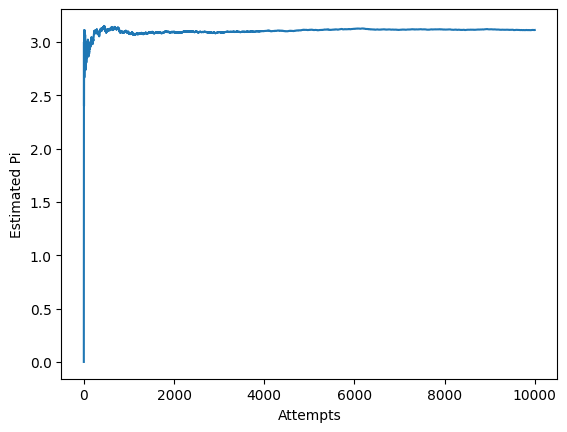

Estimated value of π = 3.112


interactive(children=(IntSlider(value=1000, description='num_samples', max=10000000, min=10, step=10), Output(…

In [ ]:
import random
import matplotlib.pyplot as plt

circlePoints = 0
outsidePoints = 0
pi = []

runs = int(input('Number of runs to perform: '))
for i in range(runs):
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    if (x ** 2 + y ** 2)  <= 1:
        circlePoints += 1
    else:
        outsidePoints += 1
    pi.append((4 * circlePoints) / (circlePoints + outsidePoints))
plt.plot(pi)
plt.ylabel('Estimated Pi')
plt.xlabel('Attempts')
plt.show()
pi = (4 * circlePoints) / (circlePoints + outsidePoints)
print('Estimated value of π =', pi)
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Initialize x and y globally
x = np.random.rand(10000)
y = np.random.rand(10000)

# Function to estimate π using Monte Carlo method
def monte_carlo_pi(num_samples):
    global x, y
    inside_circle = (x[:num_samples]**2 + y[:num_samples]**2) <= 1
    pi_estimate = 4 * np.sum(inside_circle) / num_samples
    return pi_estimate, inside_circle

# Function to update plot
def update_plot(num_samples):
    pi_estimate, inside_circle = monte_carlo_pi(num_samples)
    plt.figure(figsize=(8, 8))
    plt.scatter(x[:num_samples][inside_circle], y[:num_samples][inside_circle], color='blue', alpha=0.5, label='Inside Circle')
    plt.scatter(x[:num_samples][~inside_circle], y[:num_samples][~inside_circle], color='red', alpha=0.5, label='Outside Circle')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Monte Carlo Estimation of π (Samples: {num_samples}, π ≈ {pi_estimate:.4f})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Create interactive widget
interact(update_plot, num_samples=IntSlider(min=10, max=10000, step=10, value=1000));


![](https://raw.githubusercontent.com/mrigankdoshy/monte-carlo-simulation-pi/master/Pi/Graphs/Parallel%20-%20Threads%20VS%20Pi.png)

![](https://raw.githubusercontent.com/mrigankdoshy/monte-carlo-simulation-pi/master/Pi/Graphs/Parallel%20-%20Threads%20VS%20Time.png)

In [ ]:
%%writefile monte_carlo.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <time.h>
#include <sys/time.h>

double getRandomNumber(unsigned int *seed) {
    return (double) rand_r(seed) * 2 / (double) (RAND_MAX) - 1;
}

long double ParallelPi(long long iterations, int num_threads) {
    long long numberInCircle = 0;
    #pragma omp parallel num_threads(num_threads)
    {
        /* Since rand() is not thread-safe, we generate a seed per thread and use rand_r() to
            retrieve a thread-safe random value. */
        unsigned int seed = (unsigned int) time(NULL) + (unsigned int) omp_get_thread_num();
        #pragma omp for reduction(+: numberInCircle)
        for (long long int i = 0; i < iterations; i++) {
            double x = getRandomNumber(&seed);
            double y = getRandomNumber(&seed);
            double distanceSquared = x*x + y*y;

            if (distanceSquared <= 1)
                numberInCircle++;
        }
    }
    return 4 * numberInCircle / ((double) iterations);
}

int main() {
    struct timeval start, end;

    long long iterations = 100000000;
    int num_threads = 4;

    printf("\nTIMING PARALLEL: \n");
    gettimeofday(&start, NULL);
    long double parallelPi = ParallelPi(iterations, num_threads);
    gettimeofday(&end, NULL);
    printf("Took %f seconds\n\n", end.tv_sec - start.tv_sec + (double) (end.tv_usec - start.tv_usec) / 1000000);

    printf("Parallel: Estimated π = %.10Lf \n", parallelPi);

    return 0;
}


Writing monte_carlo.c


In [ ]:
import subprocess

def compile_and_run_c_code(num_threads, num_iterations):
    # Compile the C code
    compile_command = f"gcc -fopenmp -o monte_carlo -DNUM_THREADS={num_threads} -DNUM_ITERATIONS={num_iterations} monte_carlo.c"
    subprocess.run(compile_command, shell=True, check=True)

    # Run the compiled C code
    run_command = "./monte_carlo"
    output = subprocess.run(run_command, shell=True, check=True, capture_output=True, text=True)

    # Parse the output to extract time taken and estimated value of π
    output_lines = output.stdout.strip().split('\n')
    for line in output_lines:
        if line.startswith("Estimated"):
            estimated_pi = float(line.split()[-1])
            return estimated_pi  # Return the estimated value of π here

# Define parameters
num_threads = 4
num_iterations = 100000000

# Compile and run C code
estimated_pi = compile_and_run_c_code(num_threads, num_iterations)

print(f"Estimated π using {num_threads} threads and {num_iterations} iterations: {estimated_pi}")


Estimated π using 4 threads and 100000000 iterations: None


# ***Matrix Multiplication***

There is a mathematical algorithm for multiplying two matrices, A and B, and creating a matrix C.
![Colab Logo](https://www.learnpdc.org/PDCBeginners/_images/MM-seq.gif)


Because this algorithm is O(N3) in the sequential case, its running time gets very long as N increases. For example, each time we double the size of the rows and columns of the input matrices.

The nature of this algorithm, which calculates cell values row-by-row and independently of each other, lends itself very nicely to be parallelized. The values in the rows of A and the columns of B are only being read from, and each dot product calculation can be done independently- the order of the sequential algorithm’s computations is not necessary.

As an example of how we can use parallelism, suppose we chose two threads to compute the above example of the 4x4 matrices. In the following visualization, a thread 0 can be computing the blue values at the same time that thread 1 is computing the yellow values. It is easy to see how if the parallelization goes well, the work should get done in about half the time as the sequential version, with thread 0 computing the top half of the matrix C (rows 0, 1) and thread 1 computing the lower half (rows 2, 3).
![](https://www.learnpdc.org/PDCBeginners/_images/MM-openMP.gif)

In [11]:
%%writefile mxv_openmp.c
# include <stdlib.h>
# include <stdio.h>
# include <time.h>
# include <omp.h>

int main ( );
void test01 ( int m, int n );
void matgen ( int m, int n, double a[], double x[] );
void mxv_plain ( int m, int n, double a[], double x[], double y[] );
void mxv_plain_openmp ( int m, int n, double a[], double x[], double y[] );
void timestamp ( );

int main ( void )
{
  int i;
  int m;
  int n;

  timestamp ( );

  printf ( "\n" );
  printf ( "MXV_OPENMP:\n" );
  printf ( "  C/OpenMP version\n" );
  printf ( "  Compute matrix vector products y = A*x.\n" );

  printf ( "\n" );
  printf ( "  Number of processors available = %d\n", omp_get_num_procs ( ) );
  printf ( "  Number of threads =              %d\n", omp_get_max_threads ( ) );

  printf ( "\n" );
  printf ( "  Compare various algorithms:\n" );
  printf ( "\n" );
  printf ( "  MXV_PLAIN          - plain MxV coding.\n" );
  printf ( "  MXV_PLAIN_OPENMP  - plain MxV coding + OpenMP.\n" );
  printf ( "\n" );
  printf ( "  Algorithm                  M         N      Seconds\n" );
/*
  N = M
*/
  m = 10;

  for ( i = 1; i <= 3; i++ )
  {
    printf ( "\n" );

    n = m;
    test01 ( m, n );

    m = m * 10;
  }
/*
  N = 10 * M
*/
  m = 1;

  for ( i = 1; i <= 4; i++ )
  {
    printf ( "\n" );

    n = 10 * m;
    test01 ( m, n );

    m = m * 10;
  }
/*
  M = 10 * N
*/
  n = 1;

  for ( i = 1; i <= 4; i++ )
  {
    printf ( "\n" );

    m = 10 * n;
    test01 ( m, n );

    n = n * 10;
  }
/*
  Terminate.
*/
  printf ( "\n" );
  printf ( "MXV_OPENMP:\n" );
  printf ( "  Normal end of execution.\n" );

  printf ( "\n" );
  timestamp ( );

  return 0;
}
void test01 ( int m, int n )

{
  double *a;
  double seconds;
  double *x;
  double *y;

  a = ( double * ) malloc ( m*n * sizeof ( double ) );
  x = ( double * ) malloc (   n * sizeof ( double ) );
  y = ( double * ) malloc ( m   * sizeof ( double ) );

  matgen ( m, n, a, x );

  seconds = omp_get_wtime ( );
  mxv_plain ( m, n, a, x, y );
  seconds = omp_get_wtime ( ) - seconds;
  printf ( "  MXV_PLAIN           %8d  %8d  %14f\n", m, n, seconds );

  seconds = omp_get_wtime ( );
  mxv_plain_openmp ( m, n, a, x, y );
  seconds = omp_get_wtime ( ) - seconds;
  printf ( "  MXV_PLAIN_OPENMP   %8d  %8d  %14f\n", m, n, seconds );

  free ( a );
  free ( x );
  free ( y );

  return;
}
void matgen ( int m, int n, double a[], double x[] )

{
  int i;
  int j;
  int seed;

  seed = 1325;
/*
 Set the matrix A.
*/
  for ( j = 0; j < n; j++ )
  {
    for ( i = 0; i < m; i++ )
    {
      seed = ( 3125 * seed ) % 65536;
      a[i+j*m] = ( seed - 32768.0 ) / 16384.0;
    }
  }
/*
  Set X.
*/
  for ( i = 0; i < n; i++ )
  {
    x[i] = i + 1;
  }

  return;
}

void mxv_plain ( int m, int n, double a[], double x[], double y[] )

{
  int i;
  int j;

  for ( i = 0; i < m; i++ )
  {
    y[i] = 0.0;
    for ( j = 0; j < n; j++ )
    {
      y[i] = y[i] + a[i+j*m] * x[j];
    }
  }

  return;
}

void mxv_plain_openmp ( int m, int n, double a[], double x[], double y[] )


{
  int i;
  int j;

# pragma omp parallel \
  shared ( m, n, a, x, y ) \
  private ( i, j )

# pragma omp for
  for ( i = 0; i < m; i++ )
  {
    y[i] = 0.0;
    for ( j = 0; j < n; j++ )
    {
      y[i] = y[i] + a[i+j*m] * x[j];
    }
  }

  return;
}

void timestamp ( void )

{
# define TIME_SIZE 40

  static char time_buffer[TIME_SIZE];
  const struct tm *tm;
  time_t now;

  now = time ( NULL );
  tm = localtime ( &now );

  strftime ( time_buffer, TIME_SIZE, "%d %B %Y %I:%M:%S %p", tm );

  printf ( "%s\n", time_buffer );

  return;
# undef TIME_SIZE
}

Overwriting mxv_openmp.c


In [14]:
%%writefile my_script.sh
#!/bin/bash

gcc -c -Wall -fopenmp mxv_openmp.c
if [ $? -ne 0 ]; then
  echo "Compile error."
  exit
fi

gcc -fopenmp mxv_openmp.o
if [ $? -ne 0 ]; then
  echo "Load error."
  exit
fi
rm mxv_openmp.o
mv a.out mxv_openmp

echo "Run with 1 thread."
export OMP_NUM_THREADS=1
echo "OMP_NUM_THREADS=1" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

echo "Run with 2 threads."
export OMP_NUM_THREADS=2
echo "OMP_NUM_THREADS=2" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

echo "Run with 4 threads."
export OMP_NUM_THREADS=4
echo "OMP_NUM_THREADS=4" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

echo "Run with 8 threads."
export OMP_NUM_THREADS=8
echo "OMP_NUM_THREADS=8" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

rm mxv_openmp

echo "Normal end of execution."



Overwriting my_script.sh


In [15]:
!bash my_script.sh


Run with 1 thread.
27 March 2024 04:43:47 PM

MXV_OPENMP:
  C/OpenMP version
  Compute matrix vector products y = A*x.

  Number of processors available = 2
  Number of threads =              1

  Compare various algorithms:

  MXV_PLAIN          - plain MxV coding.
  MXV_PLAIN_OPENMP  - plain MxV coding + OpenMP.

  Algorithm                  M         N      Seconds

  MXV_PLAIN                 10        10        0.000001
  MXV_PLAIN_OPENMP         10        10        0.000007

  MXV_PLAIN                100       100        0.000053
  MXV_PLAIN_OPENMP        100       100        0.000064

  MXV_PLAIN               1000      1000        0.007450
  MXV_PLAIN_OPENMP       1000      1000        0.006663

  MXV_PLAIN                  1        10        0.000000
  MXV_PLAIN_OPENMP          1        10        0.000004

  MXV_PLAIN                 10       100        0.000005
  MXV_PLAIN_OPENMP         10       100        0.000006

  MXV_PLAIN                100      1000        0.000400
 